# Verkenning en schoonmaken van de onbeschikbare geneesmiddelen 


In [87]:
import pandas as pd
from datetime import datetime as dt
import os

## Stap één: verkenning
Het eerste wat we gaan doen is de dataset inlezen en bekijken. We maken de columns mooi en isoleren de naam van het geneesmiddel om die later makkelijker terug te kunnen zoeken. Ook isoleren we het jaar van de startdatum om hier later makkelijker op te kunnen filteren.

In [88]:
data = pd.read_csv(os.path.expanduser('~/Desktop/vrtnws_data/zorg/supplyproblems.csv'), parse_dates=['Supply Problem Start Date', 'Supply Problem End Date'])
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
data = data[data['human/veterinary'] == 'human']
data['name'] = data.name_medicinal_product.str.split().str.get(0)
data['start_year'] = pd.to_datetime(data.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [90]:
data.head()

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
0,Amoxypen 1 g,Effervescent tablet,Tube,20 (2 x 10),Amophar,2015-01-01,NaN,2016-02-01,NaN,BE218127,218127-05,human,Amoxypen,2015
1,Amoxypen 1 g,Effervescent tablet,Tube,8,Amophar,2015-01-01,NaN,2016-02-01,NaN,BE218127,218127-01,human,Amoxypen,2015
2,Buccalin,Tablet,Packaging,7,Desma,2015-01-01,NaN,2015-11-11,NaN,BE079274,079274-01,human,Buccalin,2015
3,Desloratadine Actavis 5 mg,Film-coated tablet,Blister,50,Actavis Group Ptc Ehf,2015-01-01,NaN,2015-01-01,NaN,EU/1/11/745/007,413244-01,human,Desloratadine,2015
4,Desloratadine Actavis 5 mg,Film-coated tablet,Blister,100,Actavis Group Ptc Ehf,2015-01-01,NaN,2015-01-01,NaN,EU/1/11/745/009,413262-01,human,Desloratadine,2015


## Stap twee: schoonmaken
Het volgende dat we willen doen is de dataset schoonmaken. Er is namelijk een grote kans dat er fouten in de dataset zitten. Van degene van wie de dataset hebben gekregen, begrepen we dat er geen geneesmiddelen in de dataset moeten zitten die nog onbeschikbaar waren op 12-8-2019. Dit kunnen we controleren omdat we van de info weten dat er een column is met de 'supply problem end date'. Hier zouden dus geen lege waardes in moeten zitten.

In [91]:
len(data[data.supply_problem_end_date.isna()])

563

En nu blijkt dus dat we alsnog 563 geneesmiddelen hebben waar een einddatum ontbreekt. We gaan deze subset opslaan in een variabele om beter te kunnen bekijken.

In [92]:
no_end = data[data.supply_problem_end_date.isna()]

## Stap drie: cross-referencing
Van de website van het FAGG hebben we nog twee andere datasets gehaald, namelijk de dataset met momenteel onbeschikbare geneesmiddelen en de dataset met de historiek van wijzigingen, gebaseerd op informatie van de afgelopen 30 dagen. Deze wordt dus elke dag aangepast. De historiek-dataset is gedownload op 23-10-2019. We kunnen deze twee datasets gebruiken om de geneesmiddelen zonder einddatum mee te cross-checken. Wellicht dat er, ondanks het bericht dat we kregen, alsnog geneesmiddelen in de dataset zitten die nog altijd onbeschikbaar zijn. 

In [93]:
current = pd.read_csv(os.path.expanduser('~/Desktop/vrtnws_data/zorg/current.csv'), parse_dates=['SUPPLY PROBLEM START DATE', 'SUPPLY PROBLEM EXPECTED END DATE'])
current.columns = current.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
changes = pd.read_csv('~/Desktop/vrtnws_data/zorg/changes.csv', parse_dates=['BEGINDATUM ONBESCHIKBAARHEID'])
changes.columns = changes.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')

Ook deze datasets kunnen fouten bevatten. Een veel voorkomende fout in datasets zijn ontbrekende dan wel duplicate waardes. Daarom moeten we op zoek naar een unieke ID om te controleren of onze datasets dubbele waardes bevatten. Daarvoor moeten we de info van de datasets bekijken. 

In [94]:
current.info()
changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 13 columns):
name                                558 non-null object
authorisation_holder                558 non-null object
pharmaceutical_form                 558 non-null object
packaging_type                      558 non-null object
pack_size                           558 non-null object
cti_extended                        558 non-null object
cnk                                 558 non-null object
fmd_code                            558 non-null object
supply_problem_start_date           558 non-null datetime64[ns]
supply_problem_expected_end_date    557 non-null datetime64[ns]
supply_problem_reason               558 non-null object
parallel_distributor                0 non-null float64
derogation                          558 non-null object
dtypes: datetime64[ns](2), float64(1), object(10)
memory usage: 56.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data co

Hier zien we dat beide datasets de column 'cti_extended' bevat, en als we terugscrollen zien we dat onze oorspronkelijke dataset deze ook bevat. Een rondje op Google leert ons dat CTI Extended een unieke code is die het FAGG aan een bepaalde verpakkingstype van een bepaald geneesmiddel meegeeft. Dat is dus precies wat we zoeken. 

In [95]:
len(current.index)

558

In [96]:
current.cti_extended.nunique()

558

In [97]:
len(changes.index)

602

In [98]:
changes.cti_extended.nunique()

482

Uit bovenstaande zien we dat de huidige onbeschikbare geneesmiddelen allemaal uniek zijn, terwijl er in de changes-dataset wel duplicaten zitten. Dit kan te verklaren zijn, maar we gaan die dataset voor nu wel even parkeren en beginnen met de current-dataset. We gaan kijken of er onder de geneesmiddelen zonder einddatum wellicht geneesmiddelen zitten die nu nog onbeschikbaar zijn. Dat doen we door de twee datasets te mergen en te kijken of er rijen zijn die in beide datasets voorkomen. Eerst moeten we controleren of de datasets een beetje te vergelijken zijn. Dat ze dezelfde columnnamen hebben wil niet zeggen dat ze ook op dezelfde manier de data hebben ingevoerd. 

In [99]:
no_end.head()

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
1591,Midazolam Mylan 5 mg/ml,Solution for injection,Ampoule,10 x 10 ml,Mylan,2016-12-30,2017-02-03,NaT,New batch(es) not yet available,BE339403,339403-04,human,Midazolam,2016
1616,"Zolmitriptan Teva Instant 2,5 mg",Orodispersible tablet,Blister,3,Teva Pharma Belgium,2017-01-05,2017-06-15,NaT,New batch(es) not yet available,BE365836,365836-02,human,Zolmitriptan,2017
1672,Lansoprazol Sandoz 30 mg,"Gastro-resistant capsule, hard",Bottle,56,Sandoz,2017-01-20,2017-01-27,NaT,NaN,BE281967,281967-03,human,Lansoprazol,2017
1702,Lidocaine Accord 20 mg/ml,Solution for injection,Ampoule,20 x 10 ml,Accord Healthcare,2017-02-01,2017-05-15,NaT,New batch(es) not yet available,BE479342,479342-02,human,Lidocaine,2017
1703,Lorazetop 1 mg,Tablet,Blister,60,Apotex Europe,2017-02-01,2019-02-01,NaT,Production problems,BE193602,193602-03,human,Lorazetop,2017


In [100]:
current.head()

,name,authorisation_holder,pharmaceutical_form,packaging_type,pack_size,cti_extended,cnk,fmd_code,supply_problem_start_date,supply_problem_expected_end_date,supply_problem_reason,parallel_distributor,derogation
0,"""Aacidexam 5 mg/ml""",Aspen Pharma Trading Ltd (IE),Solution for injection,"""Ampoule""",1 ml,080026-01,"""1750132""","""05060249176732""",2019-09-30,2019-12-07,Production problems,NaN,no
1,"""Abacavir/Lamivudin Sandoz 600 mg - 300 mg""",Sandoz NV (BE),Film-coated tablet,"""Blister""",30,500622-01,"""3550647""","""07613421010430""",2019-03-01,2020-01-15,New batch(es) not yet available,NaN,no
2,"""Accupril 40 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",56,150963-01,"""1578129""","""05415062302880""",2019-08-22,2019-12-15,New batch(es) not yet available,NaN,no
3,"""Accuretic 10 mg - 12,5 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",28,164367-01,"""1088673""","""05415062302903""",2019-06-12,2019-10-31,New batch(es) not yet available,NaN,no
4,"""Accuretic 20 mg - 12,5 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",28,164376-01,"""1088681""","""05415062302910""",2018-11-22,2019-11-10,New batch(es) not yet available,NaN,no


Er vallen een aantal dingen op. Zo hebben in de current-dataset een aantal waardes (name, packaging type) apostrofs om de inhoud gekregen. Dat maakt het onmogelijk om deze waardes te vergelijken met de andere dataset. We kunnen dit oplossen door de dataset aan te passen.

In [101]:
current['name'] = current.name.str.replace('"', '')
current['packaging_type'] = current.packaging_type.str.replace('"', '')

In [102]:
current.head()

,name,authorisation_holder,pharmaceutical_form,packaging_type,pack_size,cti_extended,cnk,fmd_code,supply_problem_start_date,supply_problem_expected_end_date,supply_problem_reason,parallel_distributor,derogation
0,Aacidexam 5 mg/ml,Aspen Pharma Trading Ltd (IE),Solution for injection,Ampoule,1 ml,080026-01,"""1750132""","""05060249176732""",2019-09-30,2019-12-07,Production problems,NaN,no
1,Abacavir/Lamivudin Sandoz 600 mg - 300 mg,Sandoz NV (BE),Film-coated tablet,Blister,30,500622-01,"""3550647""","""07613421010430""",2019-03-01,2020-01-15,New batch(es) not yet available,NaN,no
2,Accupril 40 mg,Pfizer SA (BE),Film-coated tablet,Blister,56,150963-01,"""1578129""","""05415062302880""",2019-08-22,2019-12-15,New batch(es) not yet available,NaN,no
3,"Accuretic 10 mg - 12,5 mg",Pfizer SA (BE),Film-coated tablet,Blister,28,164367-01,"""1088673""","""05415062302903""",2019-06-12,2019-10-31,New batch(es) not yet available,NaN,no
4,"Accuretic 20 mg - 12,5 mg",Pfizer SA (BE),Film-coated tablet,Blister,28,164376-01,"""1088681""","""05415062302910""",2018-11-22,2019-11-10,New batch(es) not yet available,NaN,no


We zien dat we dat probleem nu hebben opgelost. Op deze manier kunnen we gaan mergen. We mergen de dataset in ieder geval op de cti_extended waarde én op de startdatum van de supply problems, om de kans te vergroten dat we dezelfde rijen te pakken hebben. We voegen ook een indicator toe, waar we op kunnen filteren als we willen zien welke rijen in beide datasets voorkomen. We doen een left join, omdat we ook willen weten welke waardes niet in beide datasets voorkomen, maar wel in de no_end dataset. 

In [103]:
merged = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='left', indicator='exists')

In [104]:
merged.head()

,name_medicinal_product,pharmaceutical_form_x,packaging_type_x,pack_size_x,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason_x,authorisation_number,...,pharmaceutical_form_y,packaging_type_y,pack_size_y,cnk,fmd_code,supply_problem_expected_end_date,supply_problem_reason_y,parallel_distributor,derogation,exists
0,Midazolam Mylan 5 mg/ml,Solution for injection,Ampoule,10 x 10 ml,Mylan,2016-12-30,2017-02-03,NaT,New batch(es) not yet available,BE339403,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
1,"Zolmitriptan Teva Instant 2,5 mg",Orodispersible tablet,Blister,3,Teva Pharma Belgium,2017-01-05,2017-06-15,NaT,New batch(es) not yet available,BE365836,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
2,Lansoprazol Sandoz 30 mg,"Gastro-resistant capsule, hard",Bottle,56,Sandoz,2017-01-20,2017-01-27,NaT,NaN,BE281967,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
3,Lidocaine Accord 20 mg/ml,Solution for injection,Ampoule,20 x 10 ml,Accord Healthcare,2017-02-01,2017-05-15,NaT,New batch(es) not yet available,BE479342,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
4,Lorazetop 1 mg,Tablet,Blister,60,Apotex Europe,2017-02-01,2019-02-01,NaT,Production problems,BE193602,...,Tablet,Blister,60,"""3215894""","""08712755216002""",2019-12-31,Temporary suspension of the commercialisation,NaN,no,both


In [105]:
merged.exists.value_counts()

left_only     292
both          271
right_only      0
Name: exists, dtype: int64

We zien dat er 271 rijen zijn die in beide datasets voorkomen. Om zeker te weten dat we allemaal rijen hebben die inderdaad hetzelfde zijn, mergen we nog een keer maar dan met twee extra variabeles.

In [106]:
pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date', 'packaging_type', 'pharmaceutical_form'], how='left', indicator='exists').exists.value_counts()

left_only     296
both          267
right_only      0
Name: exists, dtype: int64

We zien dat er een verschil is van vier waardes. Al we willen weten welke waardes dat zijn moeten we de twee datasets met elkaar vergelijken om het verschil te zien. Dat doen we door eerst van beide datasets de rijen te isoleren die in beide sets zouden voorkomen. 

In [107]:
merged_2 = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date', 'packaging_type', 'pharmaceutical_form'], how='left', indicator='exists')

In [108]:
both = merged[merged.exists == 'both']
both_2 = merged_2[merged_2.exists == 'both']

In [109]:
pd.concat([both, both_2]).loc[
    both.index.symmetric_difference(both_2.index)
]

/Users/fmeijer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,authorisation_holder,authorisation_number,cnk,cti_extended,derogation,exists,fmd_code,human/veterinary,mah,name_medicinal_product,...,pharmaceutical_form,pharmaceutical_form_x,pharmaceutical_form_y,start_year,supply_problem_end_date,supply_problem_expected_end_date,supply_problem_presumed_end_date,supply_problem_reason_x,supply_problem_reason_y,supply_problem_start_date
60,Merck Sharp & Dohme BV (NL),EU/1/03/262/011,"""3621158""",490435-01,no,both,"""""",human,Merck Sharp & Dohme,Emend 125 mg,...,NaN,Powder for oral suspension,Powder for oral suspension,2018,NaT,2019-10-31,2019-07-31,Production problems,Production problems,2018-11-01
234,Pfizer SA (BE),BE291706,"""2473809""",291706-01,no,both,"""""",human,Pfizer,Mencevax ACWY,...,NaN,Powder and solvent for solution for injection,Powder and solvent for solution for injection,2019,NaT,2019-12-31,2019-07-30,New batch(es) not yet available,New batch(es) not yet available,2019-05-23
301,Theramex Ireland Ltd (IE),BE223237,"""1634948""",223237-02,no,both,"""05407003822441""",human,Theramex Ireland,Feminova Plus 50mcg/10mcg/24hrs,...,NaN,Transdermal patch,"Transdermal patch, Transdermal patch",2019,NaT,2019-12-31,2019-12-31,Production problems,Production problems,2019-06-10
489,Sanofi Pasteur Europe SA (FR),BE158724,"""0320879""",158724-01,no,both,"""03664798005196""",human,Sanofi Pasteur Europe,"Act-HIB 10 µg/0,5 ml",...,NaN,Powder and solvent for solution for injection,Powder and solvent for solution for injection,2019,NaT,2019-12-31,2019-08-22,Production problems,Production problems,2019-07-23


In [110]:
values = pd.concat([both, both_2]).loc[
    both.index.symmetric_difference(both_2.index)
]

/Users/fmeijer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [111]:
values[['cti_extended', 'supply_problem_start_date', 'packaging_type_x', 'packaging_type', 'packaging_type_y', 'pharmaceutical_form_x', 'pharmaceutical_form', 'pharmaceutical_form_y']]

,cti_extended,supply_problem_start_date,packaging_type_x,packaging_type,packaging_type_y,pharmaceutical_form_x,pharmaceutical_form,pharmaceutical_form_y
60,490435-01,2018-11-01,Sachet,NaN,"Sachet, undefined, undefined",Powder for oral suspension,NaN,Powder for oral suspension
234,291706-01,2019-05-23,Pre-filled syringe / Vial,NaN,"Vial, Pre-filled syringe",Powder and solvent for solution for injection,NaN,Powder and solvent for solution for injection
301,223237-02,2019-06-10,Sachet,NaN,"Sachet, Sachet",Transdermal patch,NaN,"Transdermal patch, Transdermal patch"
489,158724-01,2019-07-23,Vial,NaN,"Vial, Vial",Powder and solvent for solution for injection,NaN,Powder and solvent for solution for injection


Nu zien we waar de mismatch vandaan komt: er zitten dubbelingen in de packaging_type_y en pharmaceutical_form_y (afkomstig van de 'current' dataset) die niet matchen met de oorspronkelijke dataset. Ondanks die fout lijken de waardes verder wel hetzelfde te zijn, en dus disregarden we deze wijzigingen en gaan we verder met onze oorspronkelijke dataset 'merged'.

We hebben de waardes die in beide datasets voorkomen al geïsoleerd uit deze dataset: 271 geneesmiddelen uit onze oorspronkelijke dataset zijn blijkbaar nog steeds onbeschikbaar. Dat betekent wel dat er nog 292 waardes overblijven waarvan we niet weten wat ermee gebeurd is. Het kan zijn dat ze in de tussentijd weer beschikbaar zijn geworden, maar dat weten we niet zeker. Het kan immers ook een fout zijn die bij de makers van de dataset ligt. 

Gelukkig hebben we nog een andere dataset die we kunnen cross-checken: die van de 'changes'. Dat is de historiek met wijzigingen van de afgelopen dertig dagen (gedownload op 23-10-2019). Laten we die dus eerst nog eens beter bekijken. 

In [112]:
changes.head()

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
0,"""1-Alpha Leo 0,25 µg""","Capsule, zacht",Blisterverpakking,30,118456-01,676569.0,"""05702191018165""",Leo Pharma NV,2019-09-13,2019-10-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
1,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,233834-02,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
2,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,233834-02,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Vermoedelijke einddatum gewijzigd
3,"""1-Alpha Leo IV 1 µg/0,5 ml""",Oplossing voor injectie,Blisterverpakking,10 x 0.5 ml,164595-01,1128719.0,"""05702191019353""",Leo Pharma NV,2018-10-03,2020-01-17,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
4,"""Aacidexam 5 mg/ml""",Oplossing voor injectie,Ampul,1 ml,080026-01,1750132.0,"""05060249176732""",Aspen Pharma Trading Ltd,2019-09-30,2019-12-07,Productieproblemen,NaN,Nieuwe onbeschikbaarheid


We zien dat er een 'reden_delta' column bestaat, waar de reden voor de wijziging in staat opgenomen. We zien ook al een aantal keer 'terug beschikbaar' staan. Dat is dus het eerste waar we naar gaan kijken. Maar eerst:

Let op: we hadden net geconcludeerd dat er dubbelingen in deze dataset zitten, op basis van een check van de ID's. We moeten dus ook uitzoeken waar deze dubbelingen vandaan komen. 

In [113]:
len(changes[changes.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid'])].index)

114

Een mogelijke verklaring voor de dubbelingen is dat de changes-dataset een cumulatieve dataset is, waar alle wijzigingen in blijven staan. Dan kan een geneesmiddel dus meerdere entries hebben, bijvoorbeeld zowel als de einddatum wijzigt als wanneer deze opnieuw beschikbaar is. Dat kunnen we controleren door een groupby te doen op de cti_extended en de startdatum van de onbeschikbaarheid en te tellen hoeveel unieke waardes in de column 'reden_delta' voorkomen. 

In [115]:
changes.groupby(['cti_extended', 'begindatum_onbeschikbaarheid']).reden_delta.nunique().sort_values(ascending=False)

cti_extended  begindatum_onbeschikbaarheid
283534-01     2019-09-25                      3
538595-01     2019-09-30                      2
145932-01     2019-09-06                      2
233834-02     2019-08-19                      2
439171-04     2019-09-20                      2
235575-07     2019-09-26                      2
235864-02     2019-09-26                      2
441883-07     2019-03-08                      2
443441-04     2019-07-09                      2
443457-04     2019-06-12                      2
240186-01     2019-08-19                      2
147576-03     2019-08-06                      2
244535-05     2019-06-06                      2
329752-01     2019-04-04                      2
229564-02     2019-09-23                      2
244711-01     2019-06-24                      2
245481-02     2019-09-26                      2
143525-02     2019-09-06                      2
141425-02     2019-08-28                      2
141407-04     2019-05-28                     

Nu zien we inderdaad dat het een cumulatieve dataset betreft. En nu we dit weten, kunnen we de datasets met elkaar gaan vergelijken. Eerst isoleren we de overgebleven waardes uit merged, en dan vergelijken we die als eerste met de geneesmiddelen in de historiek waarvan we weten dat die opnieuw beschikbaar zijn geworden in de afgelopen 30 dagen. 

In [119]:
indices = merged[merged.exists == 'both'].index

In [120]:
merged.drop(indices, inplace=True)

In [121]:
leftovers = merged.drop(columns=['name_y', 'authorisation_holder', 'pharmaceutical_form_y', 'packaging_type_y', 'pack_size_y', 'cnk', 'fmd_code', 'supply_problem_expected_end_date', 'supply_problem_reason_y', 'parallel_distributor', 'derogation', 'exists'])

In [122]:
leftovers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 556
Data columns (total 14 columns):
name_medicinal_product              292 non-null object
pharmaceutical_form_x               292 non-null object
packaging_type_x                    291 non-null object
pack_size_x                         292 non-null object
mah                                 292 non-null object
supply_problem_start_date           292 non-null datetime64[ns]
supply_problem_presumed_end_date    284 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             287 non-null object
authorisation_number                292 non-null object
cti_extended                        292 non-null object
human/veterinary                    292 non-null object
name_x                              292 non-null object
start_year                          292 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 34.2+ KB


In [123]:
available = changes[changes.reden_delta == 'Terug beschikbaar']

Ook hier moeten we controleren of er dubbelingen in de subset zitten. Dat doen we als volgt: 

In [128]:
available[available.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'farmaceutische_vorm'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
28,"""Ameluz 78 mg/g""",Gel,Tube,2 g,412745-01,3188455.0,"""""",Biofrontera Bioscience GmbH,2018-02-01,2019-09-01,Tijdelijke stopzetting van de commercialisatie,NaN,Terug beschikbaar
73,"""Captopril Sandoz 25 mg""",Tablet,Blisterverpakking,90,229564-02,2393007.0,"""07613421010164""",Sandoz NV,2019-09-23,2019-12-31,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
96,"""Clarithromycin Krka 500 mg""",Filmomhulde tablet,Blisterverpakking,20,503360-05,3566759.0,"""03838989676384""","Krka, D.D. Novo Mesto",2019-05-24,2019-11-30,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
121,"""Corsodyl 2 mg/ml""",Mondspoeling,Fles,200 ml,106802-02,NaN,"""""",Glaxosmithkline Consumer Healthcare SA,2019-10-15,2019-12-02,Productieproblemen,NaN,Terug beschikbaar
188,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,100,274793-10,2388684.0,"""07613421008758""",Sandoz NV,2019-01-02,2020-02-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
189,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,60,274793-09,2388676.0,"""07613421008772""",Sandoz NV,2019-04-02,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
190,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,30,274793-05,2388668.0,"""07613421008765""",Sandoz NV,2019-06-13,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
191,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,60,274793-09,2388676.0,"""07613421008772""",Sandoz NV,2019-04-02,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
192,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,30,274793-05,2388668.0,"""07613421008765""",Sandoz NV,2019-06-13,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
193,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,30,274793-05,2388668.0,"""07613421008765""",Sandoz NV,2019-06-13,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar


Er blijken inderdaad duplicates in te zitten en dus gaan we die eerst eruit halen. Dan kunnen we deze subset mergen met de leftovers dataset. 

In [129]:
available_clean = available.drop_duplicates(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'verpakkingsgrootte'])

In [130]:
more_leftovers = pd.merge(leftovers, available_clean, how='outer', left_on=['cti_extended', 'supply_problem_start_date'], right_on=['cti_extended', 'begindatum_onbeschikbaarheid'], indicator='exists')

In [131]:
more_leftovers.exists.value_counts()

left_only     215
right_only     93
both           77
Name: exists, dtype: int64

We houden nu 215 waardes over die alleen in leftovers voorkomen. We hebben een overlap van 77 waardes, dat zijn dus 77 geneesmiddelen uit de originele dataset die weer beschikbaar zijn geworden in de afgelopen 30 dagen. En er zijn nog 93 waardes die alleen in de historiek voorkomen, dat wil zeggen dat deze geneesmiddelen waarschijnlijk een startdatum na 12-8-2019 hadden, maar inmiddels al wel weer beschikbaar zijn, en om die reden momenteel niet in de dataset zitten. Dat is iets wat we nog moeten bekijken, want we willen natuurlijk een zo volledig mogelijk beeld hebben. Deze gaan we dus even opzij zetten in een andere variabele.

In [133]:
available_others = more_leftovers[more_leftovers.exists == 'right_only']

We willen natuurlijk ook kijken naar de geneesmiddelen die weer beschikbaar zijn, want die hebben we wellicht nodig om onze primaire dataset mee te updaten. We weten dan nog niet op welke datum ze precies weer beschikbaar zijn geworden, en dat is wel vervelend. We moeten dat dus nog navragen, maar dat doen we eenvoudiger als we een csv hebben met de 77 geneeesmiddelen uit de dataset waarvan we weten dat ze inmiddels weer beschikbaar zijn.

In [232]:
more_leftovers[more_leftovers.exists == 'both'].to_csv('zorg/weer_beschikbaar.csv', index=False)

We gaan ook nog even verder kijken naar de overgebleven geneesmiddelen. Wellicht dat de rest van de changes-dataset hier ons meer over kan vertellen.

In [135]:
even_more_lo = more_leftovers[(more_leftovers.exists != 'both') & (more_leftovers.exists != 'right_only')]

In [136]:
len(even_more_lo.index)

215

In [137]:
even_more_lo = even_more_lo.drop(columns=['benaming', 'farmaceutische_vorm', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code', 'vergunninghouder', 'begindatum_onbeschikbaarheid', 'vermoedelijke_einddatum_onbeschikbaarheid', 'reden_onbeschikbaarheid', 'parallel_verdeler', 'reden_delta', 'exists'])

We halen alle waardes uit changes die niet overeenkomen met de reden_delta 'terug beschikbaar'. Ook hier zullen dubbelingen in zitten, dus we moeten de set eerst opschonen. 

In [138]:
others = changes[changes.reden_delta != 'Terug beschikbaar']

In [139]:
others_clean = others.drop_duplicates(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code'])

In [140]:
len(others_clean.index)

383

In [141]:
leftovers_final = pd.merge(even_more_lo, others_clean, how='left', left_on=['cti_extended', 'supply_problem_start_date'], right_on=['cti_extended', 'begindatum_onbeschikbaarheid'], indicator='exists')

In [142]:
leftovers_final.exists.value_counts()

left_only     214
both            1
right_only      0
Name: exists, dtype: int64

We hebben nog één overlap over. Dat wil zeggen dat we 214 waardes hebben waar we op dit moment geen uitsluitsel over kunnen geven wat daar de huidige status van is. Het kan zijn dat ze alweer beschikbar zijn, maar we weten het niet zeker. Dat moeten we dus navragen bij de makers van de dataset. 

## Stap vijf: verdere exploratie van de dataset

Nu we de dataset voor een deel hebben schoongemaakt, kunnen we even verder kijken naar de variabele die we net opzij hebben gezet: namelijk de subset van 'available' (de geneesmiddelen die weer beschikbaar zijn) die niet in onze dataset zaten. Laten we even kijken naar deze set. 

In [145]:
available_others = available_others.drop(columns=['name_medicinal_product', 'pharmaceutical_form_x', 'packaging_type_x', 'pack_size_x', 'mah', 'supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason_x', 'authorisation_number', 'human/veterinary', 'name_x', 'start_year'])

In [147]:
available_others.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 292 to 384
Data columns (total 14 columns):
cti_extended                                 93 non-null object
benaming                                     93 non-null object
farmaceutische_vorm                          93 non-null object
verpakkingstype                              92 non-null object
verpakkingsgrootte                           93 non-null object
cnk                                          92 non-null float64
fmd_code                                     93 non-null object
vergunninghouder                             93 non-null object
begindatum_onbeschikbaarheid                 93 non-null datetime64[ns]
vermoedelijke_einddatum_onbeschikbaarheid    93 non-null object
reden_onbeschikbaarheid                      93 non-null object
parallel_verdeler                            0 non-null float64
reden_delta                                  93 non-null object
exists                                       93 non-n

In [148]:
available_others.head()

,cti_extended,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta,exists
292,118456-01,"""1-Alpha Leo 0,25 µg""","Capsule, zacht",Blisterverpakking,30,676569.0,"""05702191018165""",Leo Pharma NV,2019-09-13,2019-10-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
293,233834-02,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
294,244535-05,"""Actonel 35 mg Wekelijks """,Filmomhulde tablet,Blisterverpakking,12,1768548.0,"""05407003820041""",Theramex IrelandLtd,2019-06-06,2019-10-11,Productieproblemen,NaN,Terug beschikbaar,right_only
295,374866-01,"""Altriabak 0,25 mg/ml""","Oogdruppels, oplossing",Container met druppelpipet,5 ml,2755734.0,"""03662042999291""",Laboratoires Thea,2019-08-20,2019-10-16,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
296,532222-01,"""Aprepitant Teva 125 mg + 80 mg""","Capsule, hard, Capsule, hard","Blisterverpakking, Blisterverpakking",125 mg + 2 x 80 mg,3806650.0,"""05407003826432""",TevaBV,2019-08-23,2019-10-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only


In [150]:
len(available_others[available_others.begindatum_onbeschikbaarheid > '2019-08-12'])

78

We hebben dus 78 geneesmiddelen met een startdatum later dan 12-8-2019. Deze geneesmiddelen zijn inmiddels ook alweer beschikbaar, maar voor de volledigheid van de dataset willen we toch weten welke geneesmiddelen dit zijn zodat we ze kunnen toevoegen aan de oorspronkelijke dataset. We zetten ze dus apart in een variabele die we hopelijk later terug kunnen voegen bij de hoofd-dataset. 

In [151]:
late_start = available_others[available_others.begindatum_onbeschikbaarheid > '2019-08-12']

Hoe zit het met die andere geneesmiddelen? Het zijn er niet zo veel, dus we kunnen ze zo wel even bekijken om te zien of er iets bijzonders aan is. 

In [153]:
available_others[available_others.begindatum_onbeschikbaarheid <= '2019-08-12'].sort_values(by='begindatum_onbeschikbaarheid', ascending=False)

,cti_extended,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta,exists
317,051563-01,"""Fenistil 0.1 %""","Druppels voor oraal gebruik, oplossing",Container met druppelpipet,20 ml,2565950.0,"""""",Glaxosmithkline Consumer Healthcare SA,2019-08-12,2019-10-21,Logistieke problemen,NaN,Terug beschikbaar,right_only
360,510044-01,"""Perindopril Teva 2,5 mg""",Filmomhulde tablet,Verpakking,30,3624012.0,"""05407003824308""",Teva Pharma BelgiumNV,2019-08-08,2019-10-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
372,329052-01,"""Toviaz 8 mg""",Tablet met verlengde afgifte,Blisterverpakking,84,2493211.0,"""05415062326268""",Pfizer Europe MA EEIG,2019-08-08,2019-10-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
379,147576-03,"""Xanax 2 mg""",Tablet,Fles,50,676593.0,"""05415062303191""",Pfizer SA,2019-08-06,2019-10-21,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
310,422204-01,"""Docetaxel Accord 160 mg/8 ml""",Concentraat voor oplossing voor infusie,Injectieflacon,8 ml,3012911.0,"""05055565750995""",Accord Healthcare S.L.USL,2019-08-05,2019-10-08,Brexit,NaN,Terug beschikbaar,right_only
342,160587-01,"""Minitran 15 mg""",Pleister voor transdermaal gebruik,Doos,30,1033596.0,"""05099151914576""",Mylan EPDBVBA,2019-08-05,2019-09-30,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
350,255132-03,"""Novolizer Budesonide 200 µg""",Inhalatiepoeder,"Patroon, undefined",2 x 200 doses + 1 x Inhaler,2827673.0,"""05099151914606""",Mylan EPDBVBA,2019-08-05,2019-09-23,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
313,071827-03,"""Duspatalin 135 mg""",Omhulde tablet,Tablettencontainer,120,1082346.0,"""05099151913241""",Mylan EPDBVBA,2019-07-29,2019-11-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
328,001215-03,"""Imodium 2 mg""","Capsule, hard",Blisterverpakking,200,433276.0,"""03574661243788""",Johnson & Johnson Consumer NV,2019-07-19,2019-10-08,Logistieke problemen,NaN,Terug beschikbaar,right_only
335,365811-04,"""Lodoz 10 mg - 6,25 mg""",Filmomhulde tablet,Blisterverpakking,84,2639730.0,"""04054839256400""",Merck NV,2019-06-25,2019-09-25,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only


Controle in het Excel-bestand laat zien dat deze waardes inderdaad allemaal niet in de dataset zitten. Het gaat hier dus om geneesmiddelen die op of voor 12-8-2019 onbeschikbaar zijn geworden en op 12-8-2019 nog niet beschikbaar waren, maar ergens tussen 12-8-2019 en 23-10-2019 weer wel beschikbaar zijn geworden. Ook hierover zullen we nog navraag moeten doen bij de makers van de dataset: is het mogelijk een dataset te krijgen met de geneesmiddelen die nog onbeschikbaar waren op 12-8-2019, maar inmiddels wel weer beschikbaar zijn geworden?

Dat brengt ons ook op de vraag hoe het precies zit met de geneesmiddelen die nog onbeschikbaar zijn, maar niet in onze oorspronkelijke dataset zijn opgenomen. 

In [154]:
pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='right', indicator='exists').exists.value_counts()

right_only    287
both          271
left_only       0
Name: exists, dtype: int64

In [155]:
len(current.index)

558

Er zijn dus 287 waardes in de 'current' dataset die niet in onze hoofddataset voorkomen. Even kijken wat voor waardes dat zijn.

In [157]:
others_current = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='right', indicator='exists')
others_current = others_current[others_current.exists != 'both']

In [158]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 26 columns):
name_medicinal_product              0 non-null object
pharmaceutical_form_x               0 non-null object
packaging_type_x                    0 non-null object
pack_size_x                         0 non-null object
mah                                 0 non-null object
supply_problem_start_date           287 non-null datetime64[ns]
supply_problem_presumed_end_date    0 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             0 non-null object
authorisation_number                0 non-null object
cti_extended                        287 non-null object
human/veterinary                    0 non-null object
name_x                              0 non-null object
start_year                          0 non-null float64
name_y                              287 non-null object
authorisation_holder                287 non-null object
phar

In [ ]:
others_current = others_current.drop(columns=['name_medicinal_product', 'pharmaceutical_form_x', 'packaging_type_x', 'pack_size_x', 'mah', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason_x', 'authorisation_number', 'human/veterinary', 'name_x', 'start_year'])

In [165]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 14 columns):
supply_problem_start_date           287 non-null datetime64[ns]
cti_extended                        287 non-null object
name_y                              287 non-null object
authorisation_holder                287 non-null object
pharmaceutical_form_y               287 non-null object
packaging_type_y                    287 non-null object
pack_size_y                         287 non-null object
cnk                                 287 non-null object
fmd_code                            287 non-null object
supply_problem_expected_end_date    287 non-null datetime64[ns]
supply_problem_reason_y             287 non-null object
parallel_distributor                0 non-null float64
derogation                          287 non-null object
exists                              287 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), object(10)
memory usage: 31.8+ KB


In [166]:
len(others_current[others_current.supply_problem_start_date > '2019-08-12'])

242

Er zijn dus 242 geneesmiddelen met een startdatum na 12-08-2019, wat zou kunnen verklaren waarom ze er niet in zijn opgenomen. Maar we weten dat er ook een aantal geneesmiddelen zijn uit deze dataset die wél in onze dataset zitten, dus daar zit duidelijk een inconsistentie. We zullen hierover navraag moeten doen. Nogmaals, het is belangrijk dat we een dataset hebben die volledig is, de cutoff-date van 12-8-2019 is behoorlijk arbitrair en wordt dus ook niet volledig gehandhaafd. We willen dus een dataset met alle geneesmiddelen erin, ook met een startdatum na 12-8-2019, ook degenen die nu nog onbeschikbaar zijn. In ieder geval up to date tot de dag van vandaag. 

In [167]:
len(others_current[others_current.supply_problem_start_date <= '2019-08-12'])

45

Hier zien we dat de overige geneesmiddelen een startdatum hadden voor of op 12-8-2019. Deze geneesmiddelen zijn dus momenteel nog steeds onbeschikbaar, en zitten niet in onze hoofd-dataset. We zouden deze geneesmiddelen kunnen toevoegen aan de dataset, maar we moeten dan voorkomen dat we onze oorspronkelijke dataset gaan overschrijven: je wil altijd een oorspronkelijke kopie van je dataset bewaren, om veranderingen tegen af te zetten en eventuele fouten recht te kunnen zetten. 

In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [169]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 14 columns):
supply_problem_start_date           287 non-null datetime64[ns]
cti_extended                        287 non-null object
name_y                              287 non-null object
authorisation_holder                287 non-null object
pharmaceutical_form_y               287 non-null object
packaging_type_y                    287 non-null object
pack_size_y                         287 non-null object
cnk                                 287 non-null object
fmd_code                            287 non-null object
supply_problem_expected_end_date    287 non-null datetime64[ns]
supply_problem_reason_y             287 non-null object
parallel_distributor                0 non-null float64
derogation                          287 non-null object
exists                              287 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), object(10)
memory usage: 31.8+ KB


We zullen de current_others dataset wat op moeten schonen om ervoor te zorgen dat die dezelfde look heeft als de originele dataset. 

In [174]:
others_current.columns.tolist()

['supply_problem_start_date',
 'cti_extended',
 'name_y',
 'authorisation_holder',
 'pharmaceutical_form_y',
 'packaging_type_y',
 'pack_size_y',
 'cnk',
 'fmd_code',
 'supply_problem_expected_end_date',
 'supply_problem_reason_y',
 'parallel_distributor',
 'derogation',
 'exists']

In [176]:
others_current = others_current[[
 'name_y',
 'pharmaceutical_form_y',
 'packaging_type_y',
 'pack_size_y',
 'authorisation_holder',
 'supply_problem_start_date',
 'supply_problem_expected_end_date',
 'supply_problem_reason_y',
 'cti_extended'
]]

In [179]:
others_current.insert(7, 'supply_problem_end_date', "")

In [185]:
others_current.insert(9, 'authorisation_number', "")

In [187]:
others_current['human/veterinary'] = 'human'

In [188]:
others_current['name'] = others_current.name_y.str.split().str.get(0)

In [189]:
others_current['start_year'] = pd.to_datetime(others_current.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [190]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 14 columns):
name_y                              287 non-null object
pharmaceutical_form_y               287 non-null object
packaging_type_y                    287 non-null object
pack_size_y                         287 non-null object
authorisation_holder                287 non-null object
supply_problem_start_date           287 non-null datetime64[ns]
supply_problem_expected_end_date    287 non-null datetime64[ns]
supply_problem_end_date             287 non-null object
supply_problem_reason_y             287 non-null object
authorisation_number                287 non-null object
cti_extended                        287 non-null object
human/veterinary                    287 non-null object
name                                287 non-null object
start_year                          287 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 33.6+ KB


In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [194]:
others_current.rename(columns={
    'name_y' : 'name_medicinal_product',
    'pharmaceutical_form_y' : 'pharmaceutical_form',
    'packaging_type_y' : 'packaging_type',
    'pack_size_y' : 'pack_size',
    'authorisation_holder' : 'mah',
    'supply_problem_expected_end_date' : 'supply_problem_presumed_end_date', 
    'supply_problem_reason_y' : 'supply_problem_reason'},
    inplace=True)

In [196]:
supply_problems_update = pd.concat([data, others_current], axis=0)

In [197]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5317 entries, 0 to 557
Data columns (total 14 columns):
name_medicinal_product              5317 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5314 non-null object
pack_size                           5316 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5317 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null object
supply_problem_end_date             4754 non-null object
supply_problem_reason               3921 non-null object
authorisation_number                5317 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5317 non-null object
name                                5317 non-null object
start_year                          5317 non-null int64
dtypes: datetime64[ns](1), int64(1), object(12)
memory usage: 623.1+ KB


In [199]:
supply_problems_update.to_csv('zorg/supplyproblemsupdate.csv', index=False)

Wat valt op aan de dataset die we net hebben gemaakt? Ten eerste dat niet alle kolommen alle waardes bevatten. Als we gaan kijken, zien we dat de columns packaging_type, pack_size, presumed end date, end date en reason lege waardes bevatten. End date hebben we net uitgebreid onderzocht en er ook een aantal waardes aan toegevoegd: de waardes uit 'current' die nog niet in onze dataset zaten. Hierdoor is het logisch dat hier een aantal nul-waardes te vinden zijn. Ook voor de nulwaardes van reason en presumed end date is een logische verklaring te bedenken. Deze gegevens worden aangeleverd door de fabrikanten, en die geven misschien niet altijd een reden of een voorlopige einddatum op als ze die melding doen. 

Blijven over de packaging type en de pack size. Het zijn niet veel lege waardes, dus we kunnen ze makkelijk bekijken.

In [201]:
supply_problems_update.supply_problem_presumed_end_date = pd.to_datetime(supply_problems_update.supply_problem_presumed_end_date, format='%Y-%m-%d')

In [202]:
supply_problems_update.supply_problem_end_date = pd.to_datetime(supply_problems_update.supply_problem_end_date, format='%Y-%m-%d')

In [207]:
supply_problems_update[(supply_problems_update.packaging_type.isna()) | (supply_problems_update.pack_size.isna())]

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year


In [ ]:
Door te Googlen kunnen we erachter komen om welke ontbrekende waarden het gaat. We kunnen deze dan toevoegen aan de dataset.

In [206]:
supply_problems_update.at[43, 'pack_size'] = '5 ml'
supply_problems_update.at[1931, 'packaging_type'] = 'Blister'
supply_problems_update.at[3595, 'packaging_type'] = 'Blister'
supply_problems_update.at[5158, 'packaging_type'] = 'Blister'

In [215]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5317 entries, 0 to 557
Data columns (total 14 columns):
name_medicinal_product              5317 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5317 non-null object
pack_size                           5317 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5317 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null datetime64[ns]
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3921 non-null object
authorisation_number                5317 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5317 non-null object
name                                5317 non-null object
start_year                          5317 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 783.1+ KB


Nu we die problematiek hebben opgelost, kunnen we verder gaan kijken naar interessante vragen die we met deze dataset zouden kunnen beantwoorden. We weten van de informatie bij de dataset dat omdat het om self-reported values gaat, de fabrikant met de grootste waarde niet per se ook de fabrikant is met de meeste tekorten: sommige fabrikanten rapporteren netter dan anderen. En omdat er een sensibiliseringscampagne nodig was om de fabrikanten te laten rapporteren, kunnen de totale waardes een enigszins vertekend beeld geven. Ook wil het ontbreken van een medicijntype niet zeggen dat het hele medicijn onbeschikbaar was: het gaat immers slechts om één vorm, en dan kunnen andere vormen nog steeds aanwezig zijn. 

Dat gezegd hebbende, de volgende vragen zijn interessant:
- In welke jaren zijn de meeste meldingen gedaan?
- Welke redenen komen het meest voor voor niet-leverbaar?
- Welke fabrikanten komen het meest voor?
- Welke medicijntypes komen het meest voor?
- Welke medicijnen komen het meest voor?
- In welke gevallen ging het daadwerkelijk om een volledige voorraad die op was?
- Hoe lang duurt de gemiddelde/mean/mode onbeschikbaarheid, en is dit gegroeid?
- Is dit nog verder uit te splitsen naar fabrikanten? (Bv: Pfizer heeft de afgelopen jaren steeds vaker meldingen gedaan en ook steeds langere tekorten)
- Zijn er medicijnen bij waarbij een tekort zorgt voor een levensvatbaarheidsprobleem bij de patiëntengroep?

## In welke jaren zijn de meeste meldingen gedaan?

Hiervoor kijken we naar de column 'start_year'. 

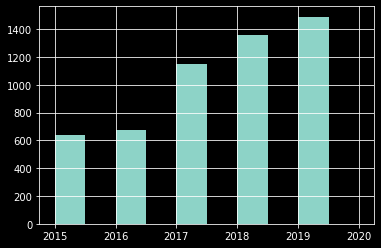

In [216]:
supply_problems_update.start_year.hist()

Om het nog wat duidelijker te bekijken, gaan we ook de waardes van dichterbij bekijken. 

In [217]:
supply_problems_update.start_year.value_counts()

2019    1489
2018    1359
2017    1152
2016     675
2015     641
2020       1
Name: start_year, dtype: int64

Zelfs als we rekening houden met het feit dat er in de beginjaren (het FAGG begon in 2014 met het bijhouden van deze cijfers) mogelijk nog niet heel veel werd gemeld, zien we een duidelijke stijging: meer dan een verdubbeling van het aantal meldingen in 2018 tov 2015. En 2019 zit nu al op het meest aantal meldingen, hoewel dit jaar nog niet om is.

### Conclusie: er worden steeds vaker medicijntekorten gemeld.

## Welke redenen komen het meest voor bij gemelde tekorten?
Hiervoor kijken we naar de kolom 'supply problem reason'. 

In [218]:
supply_problems_update.supply_problem_reason.value_counts()

New batch(es) not yet available                  2738
Production problems                               855
Logistic problems                                 111
Other reason                                      109
Temporary suspension of the commercialisation      39
Packaging problems                                 30
FMD - Serialisation                                17
FMD - Serialisation                                11
Patent dispute                                      6
Patent protection                                   5
Name: supply_problem_reason, dtype: int64

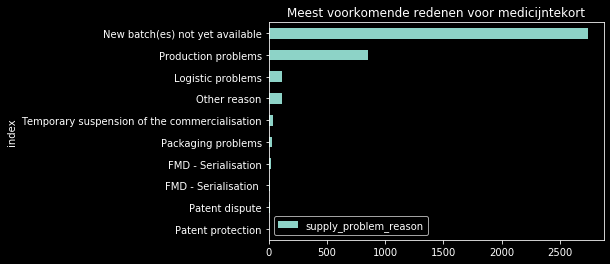

In [246]:
supply_problems_update.supply_problem_reason.value_counts().reset_index().set_index('index').sort_values(by='supply_problem_reason').plot.barh(title='Meest voorkomende redenen voor medicijntekort')

In verreweg de meeste gevallen ging het om problemen met de beschikbaarheid van nieuwe voorraden. Op de tweede plaats ging het om productieproblemen en daarna om logistieke problemen. In een klein aantal gevallen waren er patentproblemen of zelfs een tijdelijke stopzetting van de commercialisatie.

### Conclusie: de meest voorkomende redenen zijn het onbeschikbaar zijn van nieuwe batches, productieproblemen en logistieke problemen. 
#### Het is mogelijk interessant om eens te kijken naar die redenen die juist weinig voorkomen, daar zit namelijk misschien ook wel een verhaal. 

## Welke fabrikanten komen het meest voor?
Hiervoor kijken we naar de column 'mah', de main authorisation holder. 

In [235]:
supply_problems_update.mah.value_counts().head(10)

Sandoz                          828
Pfizer                          499
Mylan                           477
MSD Belgium                     250
Bayer                           235
Mylan EPD                       222
Teva Pharma Belgium             212
Sanofi Belgium                  144
Eurogenerics Afgekort "E.G."    113
Aspen Pharma Trading            112
Name: mah, dtype: int64

In [236]:
supply_problems_update.mah.nunique()

248

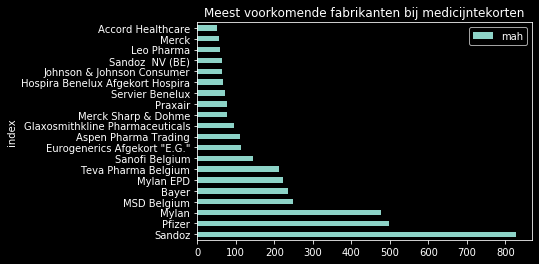

In [248]:
supply_problems_update.mah.value_counts().reset_index().set_index('index').sort_values(by='mah', ascending=False).head(20).plot.barh(title='Meest voorkomende fabrikanten bij medicijntekorten')

We kijken even waar deze bedrijven vandaan komen. Sandoz is onderdeel van Novartis, een Zwitsers bedrijf. Pfizer is Amerikaans. Mylan staat geregistreerd in Nederland (vermoedelijk vanwege de belastingen, maar dat is een ander verhaal), maar heeft een hoofdzetel in de VS. MSD Belgium is de Belgische tak van een groot Amerikaans bedrijf. Bayer is Duits. Mylan EPD is weer een andere tak van Mylan. Teva Pharma Belgium is een dochteronderneming van het Israëlische Teva Pharmaceuticals. Sanofi Belgium is de Belgische tak van het Franse Sanofi. Eurogenerics is van oorsprong Belgisch en produceert generieke geneesmiddelen. Aspen Pharma Trading is van Aspen Pharmaceuticals, een Zuid-Afrikaans bedrijf.

Vooral interessant is hoe deze absolute cijfers zich verhouden tot het marktaandeel van deze bedrijven op de Belgische en internationale markt. Via de website van het CIB-Pharma vinden we een overzicht met de marktcijfers van het moving annual total van December 2018. Daaruit blijkt dat de top-20 grootste bedrijven op de Belgische markt de volgende zijn:

- EG Generics
- Pfizer
- AbbVie
- Novartis Pharma
- GSK België
- Sandoz
- Brystol-Myers Squibb
- MSD Belgium
- Janssen Pharmaceutica
- Bayer Pharmaceuticals
- Sanofi Belgium
- AstraZeneca
- Boehringer Ingelheim
- Gilead Sciences
- Tadeka Belgium
- Teva Pharmaceuticals Belgium
- Janssen & Janssen Cons
- VIIV Healthcare
- Novo-Nordisk
- Servier
- Gilead Sciences
- Tadeka Belgium
- Teva Pharmaceuticals Belgium
- Janssen & Janssen Cons
- VIIV Healthcare
- Novo-Nordisk
- Servier

Wat dan opvalt is dat hoewel EG Generics het grootste marktaandeel heeft (met afstand), het niet even hoog staat in onbeschikbaarheid van medicijnen. Pfizer staat op beide lijstjes hoog. Mylan staat op de derde plek in onbeschikbaarheid, maar heeft slechts een laag marktaandeel (niet in de top-20). MSD België staat wel in de top-20 in beide lijstjes, net als Bayer en Teva Pharma. Het lijkt er dus op dat de tweede grootste bedrijven qua tekorten (Pfizer en Sandoz) ook relatief hoog in het marktaandeel zitten (tweede en zesde plek). Vooral Sandoz komt heel vaak voor. 

Kanttekening hier: het kan dus zijn dat dit vooral komt omdat de bedrijven het goed rapporteren, niet per se omdat zij ook het hoogste aandeel hebben. Al is het wel opvallend dat het aantal gemelde tekorten van Sandoz bijna twee keer zo groot is als van Pfizer. 

### Conclusie: De twee bedrijven met de hoogste tekorten staan ook hoog in de top-20 qua marktaandeel in 2018, verder is het een mix. Het is waarschijnlijk interessanter om te gaan kijken naar cross-checks, zoals welke medicijntypes veel tekort worden gemeld, of welke bedrijven steeds langere/vaker te korten melden. 

## Welke medicijnen en medicijntypes komen het meeste voor?
Hiervoor moeten we allereerst kijken naar de meest voorkomende stofnamen/merknamen, en deze vervolgens koppelen aan het juiste type medicijn.

In [249]:
supply_problems_update.name.value_counts()

Oxygène                          77
Ultravist                        41
Ranitidine                       37
Bisoprolol                       36
Lipitor                          32
Iomeron                          30
Zantac                           29
Valtran                          28
Valsartan                        27
Quetiapine                       27
Serlain                          27
Celecoxib                        26
Aciclovir                        26
Quetiapin                        26
Dalacin                          26
Co-Valsartan                     26
Mirtazapine                      25
Tadalafil                        25
Loortan                          24
Olmesartan                       24
Gadovist                         23
Euthyrox                         23
Sildenafil                       23
Paroxetine                       23
Diflucan                         23
Ibuprofen                        23
Zolmitriptan                     22
Metoprolol                  

In [250]:
supply_problems_update.name_medicinal_product.value_counts()

Oxygène Médicinal Liquide Praxair 100 % v/v    77
Gadovist 1,0 mmol/ml                           23
Ultravist 300 300 mg/ml                        22
Ultravist 370 370 mg/ml                        18
Valtran 71,197 mg/ml - 6,083 mg/ml             18
Lueva 75 µg                                    16
Cerazette 75 µg                                16
Amlor 5 mg                                     15
Serlain 50 mg                                  15
Marvelon 0,150 mg - 0,030 mg                   14
Iomeron 400 mg I/ml                            14
Mercilon 0,150 mg - 0,020 mg                   13
Eusaprim Forte 160 mg - 800 mg                 13
Desloratadin Sandoz 5 mg                       13
Medrol A 16 mg                                 12
Zantac 150 mg                                  12
Clozan 5 mg                                    12
Lipitor 80 mg                                  11
Diflucan 200 mg                                11
Serlain 100 mg                                 11


We willen deze twee (name en name_medical_product) vergelijken omdat soms de naam van het product hetzelfde is, maar de precieze dosis niet. We zien dit meteen terug bij Ultravist: staat er 41 keer in, 22 keer met 300 mg/ml, 18 keer met 370 mg/ml. Als deze tekorten tegelijkertijd voorkomen, is het interessant om te zien of dit betekent dat een volledig medicijn niet meer beschikbaar is (een van onze andere vragen). We gaan ons eerst focussen op de medicijntypes, en daar hebben we de specifieke dosis niet voor nodig. We kijken dus alleen naar de eerste naam. 

In [256]:
supply_problems_update.name.value_counts().reset_index().rename(columns={'index':'name', 'name':'count'}).to_csv('zorg/medicijnen.csv', index=False)